# Milestone 1

Digital Talent Scholarship 2018, Kelas A - Universitas Gadjah Mada

Anggota:

1. Luthfi Zharif

2. Larasati Aisyah R. A.

3. Karyadi

4. Izzan Rijal

5. Ismul Aksan

Selamat datang di notebook proyek kami! Notebook kami akan mencoba mengeksplorasi aktivitas perusahaan rintisan, atau yang biasa dikenal dengan startup menggunakan dataset berita dari [GDELT](https://www.gdeltproject.org/). Proyek ini akan terus kami perbaiki selama beberapa waktu kedepan, jadi pastikan untuk klik ~~like dan subscribe~~ star pada repo ini agar kamu bisa tahu perkembangan eksplorasi kami.

Notebook ini akan terbagi menjadi beberapa bagian, yaitu ekstraksi data, transformasi data, dan analisis. Ayo kita langsung saja!

# Ekstraksi Data
## Download

Data ini bisa diolah dengan dua cara, yakni melalui olah secara cloud maupun local. Dalam notebook ini, semua pengolahan akan dilakukan secara local. Oleh karena itu, kita perlu mengunduh data GDELT ke dalam mesin lokal terlebih dahulu.

Berikut adalah contoh script untuk mengunduh data GDELT dengan country code 'ID'. Country code ini menandakan bahwa kita hanya menyimpan data yang berhubungan dengan Indonesia. Source code ini disadur dari [Github pak Guntur Budi](https://github.com/gunturbudi/digital-talent/blob/master/RETRIEVE%20GDELT%20DATA.ipynb)

In [ ]:
import requests
import lxml.html as lh

gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits
file_list = [x for x in link_list if str.isdigit(x[0:4])]
print(file_list)

infilecounter = 0
outfilecounter = 0

import os.path
import urllib
import zipfile
import glob
import operator

local_path = os.getcwd()

fips_country_code = 'ID'

for compressed_file in file_list[infilecounter:]:
    print(compressed_file)

    # if we dont have the compressed file stored locally, go get it. 
    # Keep trying if necessary.
    while not os.path.isfile(local_path + compressed_file):
        print('downloading, '),
        urllib.request.urlretrieve(url=gdelt_base_url + compressed_file,
                           filename=local_path + compressed_file)

    # extract the contents of the compressed file to a temporary directory
    print('extracting,'),
    z = zipfile.ZipFile(file=local_path + compressed_file, mode='r')
    z.extractall(path=local_path + 'tmp/')

    # parse each of the csv files in the working directory,
    print('parsing,'),
    for infile_name in glob.glob(local_path + 'tmp/*'):
        outfile_name = local_path + 'gdelt_id/' + fips_country_code 
        + '%04i.tsv' % outfilecounter

        # open the infile and outfile
        with open(infile_name, mode='r', encoding='utf-8') as infile,
        open(outfile_name, mode='w') as outfile:
            for line in infile:
                # extract lines with our interest country code
                # Try and except to pass trouble data
                try:
                    # We extract only the lines where there is relation 
                    # about Indonesia (ID)
                    if fips_country_code in operator.
                    itemgetter(51, 37, 44)(line.split('\t')):
                        outfile.write(line)
                except:
                    pass
            outfilecounter += 1
        # delete the temporary file
        os.remove(infile_name)
    infilecounter += 1
    print('done')

## Simpan ke MySQL
Agar data bisa diakses secara local, kita bisa menyimpannya dalam database MySQL.

### Bangun koneksi ke MySQL lokal
Silakan buka phpMyAdmin atau program SQL favorit anda (HeidiSQL, Laragon), lalu buat database dengan nama 'gdelt_content_id'

In [1]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'gdelt_content_id'

# Create Connection to database
# engine = create_engine('mysql+pymysql://'+username+
# ':'+password+'@'+host+':'+port+'/'+database)

# Note: We use pymysql instead of sqlalchemy because sqlalchemy
# somehow don't allow the text query. Strange bug.
conn = pymysql.connect(
    host=host,
    port=int(port),
    user=username,
    passwd=password,
    db=database,
    charset='utf8mb4')
'''engine = create_engine('mysql+pymysql://root: @localhost:3306
/gdelt_content_id')'''

def run(sql):
    df = pd.read_sql_query(sql, conn)
    return df

### List Data dalam Folder
Di bagian ini, kita akan membaca data GDELT harian (tsv) dalam folder. Data tersebut akan dikompilasi menjadi dataframe Pandas.

In [ ]:
from os import listdir
from os.path import isfile, join
folder_id = './gdelt_id/'
files = [f for f in listdir(folder_id) if isfile(join(folder_id, f))]
print(files)

In [ ]:
# Open first file for sanity check
df_awal = pd.read_csv(folder_id + files[0],sep="\t")
df_awal.head()

### Langsung simpan ke MySQL
Untuk menyimpan data ke SQL, kita update data tabelnya untuk setiap file tsv yang ada

In [ ]:
# Read header / column names
colnames = list(pd.read_excel('CSV.header.fieldids.xlsx', 
                              sheet_name='CSV.header.dailyupdates'))

for berkas in files:
    print('Extracting ' + berkas)
    df_satuan = pd.DataFrame()
    
    # Important: If your ID0000.tsv contains header, you can delete the header
    df_satuan = pd.read_csv(folder_id + berkas, sep="\t", names= colnames)
    df_satuan.to_sql(name = database, con = engine, 
                     if_exists = 'append', index = False)

# Transformasi Data

## Cek Awal Data
Setelah data tersimpan secara sukses di MySQL, kita bisa melakukan eksplorasi sederhana. Langkah pertama yang perlu kita lakukan adalah melakukan filter artikel yang sesuai dengan topik startup. Dengan asumsi judul berita dimuat dalam URL artikel, maka kami filter kolom 'SOURCEURL' dengan menggunakan kata kunci yang berhubungan seputar startup. Sejauh ini ada beberapa kata kunci yang sesuai dengan dunia startup:

- Startup

- Start-up

- Unicorn

- Silicon-valley

- Ecommerce

- E-commerce

- Rintisan

- Perusahaan-rintisan

- Perusahaan-startup

- Bisnis-startup

- Startup-business

- Startup-digital

- Digital-startup

- Crowdfunding

- Fintech

- Marketplace

- Digital-platform

- Platform-digital


In [2]:
# SQL query to look for keyword in SOURCEURL
data_startup = run("""
SELECT 
    * 
FROM 
    gdelt_content_id
WHERE
    sourceurl LIKE '%startup%' OR
    sourceurl LIKE '%unicorn%' OR
    sourceurl LIKE '%start-up%' OR
    sourceurl LIKE '%silicon-valley%' OR
    sourceurl LIKE '%ecommerce%' OR
    sourceurl LIKE '%e-commerce%' OR
    sourceurl LIKE '%rintisan%' OR
    sourceurl LIKE '%perusahaan-rintisan%' OR
    sourceurl LIKE '%perusahaan-startup%' OR
    sourceurl LIKE '%bisnis-startup%' OR
    sourceurl LIKE '%startup-business%' OR
    sourceurl LIKE '%startup-digital%' OR
    sourceurl LIKE '%digital-startup%' OR
    sourceurl LIKE '%crowdfunding%' OR
    sourceurl LIKE '%fintech%' OR
    sourceurl LIKE '%marketplace%' OR
    sourceurl LIKE '%digital-platform%' OR
    sourceurl LIKE '%platform-digital%'
    """)

In [3]:
print(data_startup.shape)
data_startup.head()

(6408, 58)


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,798274953,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
1,798275016,20181029,201810,2018,2018.8192,GOV,GOVERNMENT,None,None,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
2,798275087,20181029,201810,2018,2018.8192,IDN,INDONESIA,IDN,None,None,...,None,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
3,798275096,20181029,201810,2018,2018.8192,IDNBUS,INDONESIA,IDN,None,None,...,10175966,4,"Permata, Jakarta Raya, Indonesia",ID,ID04,-6.1458,106.752,10175966,20181029.0,http://fintechnews.sg/25313/blockchain/blockch...
4,798359666,20181029,201810,2018,2018.8192,BUS,COMPANY,None,None,None,...,None,1,Indonesia,ID,ID,-5.0000,120.000,ID,20181029.0,https://www.dealstreetasia.com/stories/indones...


Berdasarkan hasil tersebut, kita melihat ada beberapa data yang duplikat, dilihat dari kolom 'SOURCEURL'. Data duplikat ini disinyalir ada untuk menampung beragam informasi yang berbeda pada kolom-kolom lainnya, seperti Actor1Name, Actor2Name, dll.

Untuk saat ini, kita persempit hasil kita terlebih dahulu dengan menghapus data-data yang duplikat.

In [4]:
data_startup_dup = data_startup.copy()

# Remove duplicate data, keep the first occurences
data_startup = data_startup.drop_duplicates('SOURCEURL')
data_startup.shape

(2217, 58)

Didapat ada 2217 baris berita yang unik, hampir 3 kali lebih kecil dibandingkan data duplikat sebelumnya. Sekarang kita simpan data tersebut ke dalam MySQL. Tak lupa kita simpan juga data startup yang ada duplikatnya untuk analisis selanjutnya.

In [5]:
# Save non-duplicated data to 'startup_indonesia' table
host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'gdelt_content_id'
database_name = 'startup_indonesia'
engine_s = create_engine('mysql+pymysql://'+username+':'+password+'@'+host+':'
                         +port+'/'+database)
data_startup.to_sql(database_name, engine_s)

# Save duplicated data to 'startup_indonesia_dup' table
database = 'gdelt_content_id'
database_name_dup = 'startup_indonesia_dup'
data_startup_dup.to_sql(database_name_dup, engine_s)

# Analisis Data
Dengan data yang sudah unik tersebut, kita bisa mulai analisis berita tersebut sesuai dengan keinginan kita. 

## Analisis sumber berita
Di bagian ini, kita akan menampilkan asal mula berita-berita tersebut.

In [6]:
import urllib

data_sourceurl = data_startup['SOURCEURL']
list_link = []

# for extracting domain url. Example: 
# http://fintechnews.sg/25313/blockchain/blockchain-indonesia/ --> fintechnews.sg
for link in data_sourceurl:
    list_link.append(urllib.parse.urlparse(link).netloc)
    
data_link = pd.Series(list_link)

# Count by its occurences
data_link_count = data_link.value_counts()
data_link_count

www.techinasia.com                183
www.dealstreetasia.com            158
www.thejakartapost.com            143
e27.co                             91
en.tempo.co                        63
fintechnews.sg                     44
www.ecosystemmarketplace.com       41
sglinks.com                        35
ecommerce-journal.com              33
www.techinasia.com:443             33
inc42.com                          33
www.crowdfundinsider.com           31
sg.news.yahoo.com                  30
economictimes.indiatimes.com       28
jakartaglobe.beritasatu.com        27
www.nationmultimedia.com           26
asia.nikkei.com                    22
www.thestar.com.my                 21
www.digitalnewsasia.com            17
techcrunch.com                     17
jakartaglobe.id                    17
www.bloomberg.com                  16
www.businesstimes.com.sg           16
www.straitstimes.com               16
www.forbes.com                     15
www.msn.com                        14
www.4-trader

Dari data GDELT, diketahui pemberitaan startup di Indonesia banyak dilakukan oleh techinasia.com, dealstreetasia.com, dan thejakartapost.com.

## Analisis Tren Startup Berdasarkan Waktu
Dalam bagian ini, kita akan melihat banyaknya berita startup dalam hitungan bulan. Analisis ini berguna untuk melihat kapan tren mulai terjadi, serta memprediksi apakah ada pola peningkatan atau penurunan dalam event dunia startup di Indonesia.

In [7]:
data_count = data_startup.copy()
# data_count['MonthYear'] = pd.to_datetime(data_count['MonthYear']
# .astype(str), format='%Y%m')

# Aggregate the table with count
data_count = data_count.groupby(data_count['MonthYear']).agg({'count'})
data_count = data_count.sort_index(ascending=True)
data_count['GLOBALEVENTID'].head()

,count
MonthYear,
201210,1
201304,1
201305,1
201306,5
201307,9


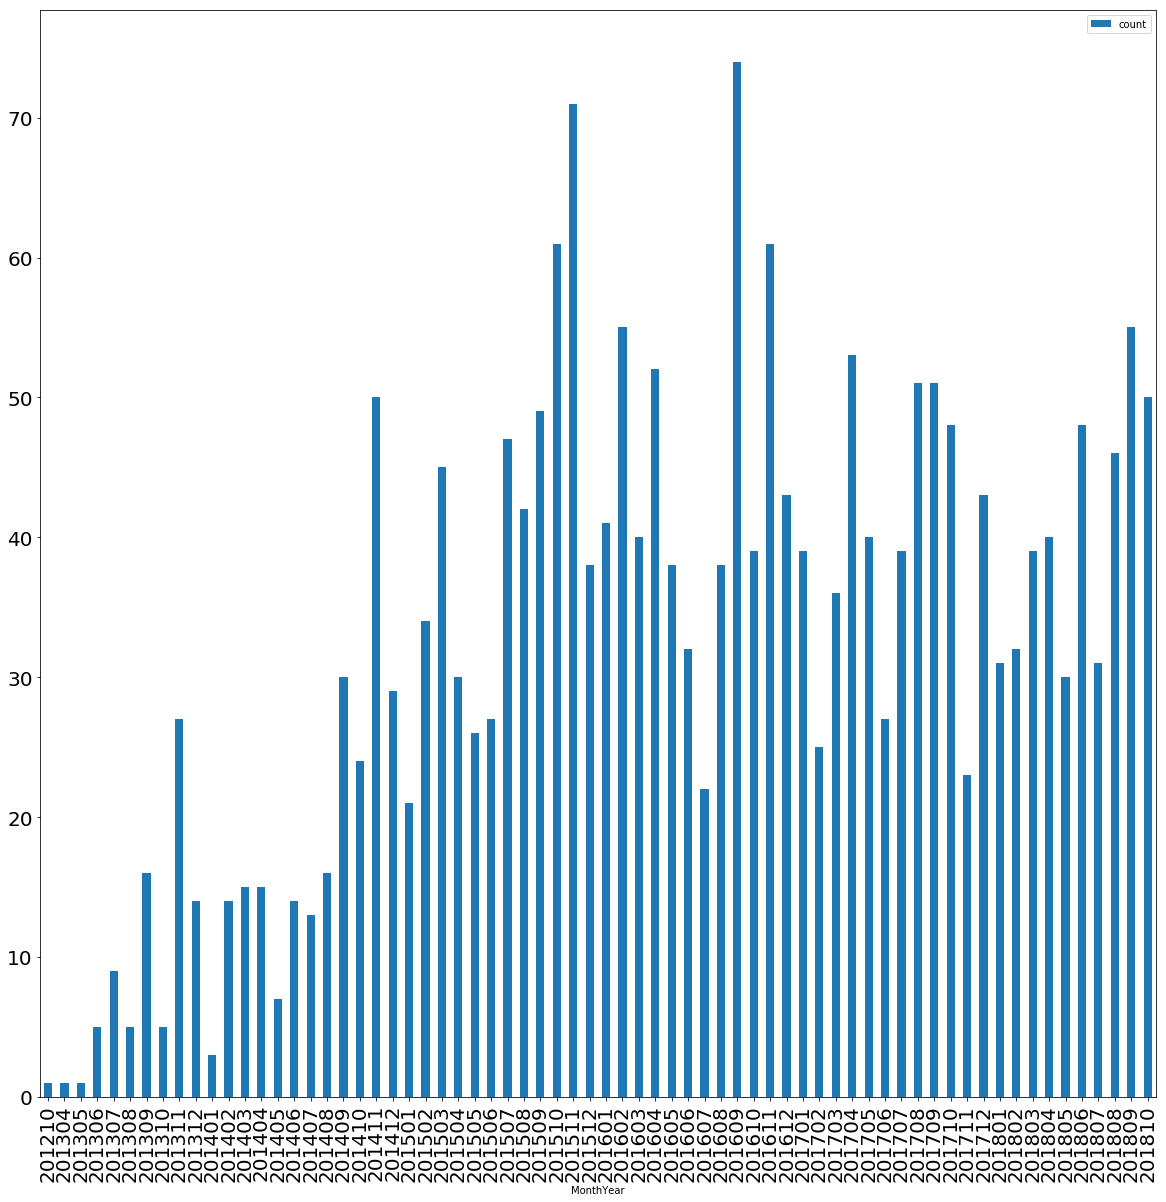

In [9]:
# display it using bar
data_count['GLOBALEVENTID'].plot(kind='bar', figsize=(20,20), fontsize=20)

Berdasarkan data tren, terlihat bahwa pemberitaan startup masih mengalami fluktuasi pada 5 tahun terakhir. Tren kenaikan terlihat pada periode 2012-2014. Booming tren startup baru terlihat pada November 2014.

# Rencana Selanjutnya
Notebook ini akan diperbarui lebih lanjut dengan beberapa ide sebagai berikut:

1. Ekstraksi teks berita

2. Analisis aktor

3. Analisis word cloud

4. Analisis sentimen
